# Initialization

## Imports and configurations

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %matplotlib inline

from zinbayes.zinbayes import ZINBayes

from pCMF import mpCMF

from state_of_art.scVI.scvi import scVI
from state_of_art.ZIFA.zifa import ZIFA
from state_of_art.ZINB_WaVE.zinb_wave import ZINB_WaVE
from state_of_art.pCMF.pcmf import pCMF

from misc.model_wrapper import ModelWrapper
from misc import print_utils, plot_utils

import edward as ed
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from scipy.stats import gaussian_kde, pearsonr
import pandas as pd
from sklearn.decomposition import FactorAnalysis
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

from edward.models import Beta, RelaxedBernoulli, Gamma, Poisson, Dirichlet, Mixture, Categorical, TransformedDistribution, Normal, PointMass

plt.style.use('seaborn-whitegrid')

In [3]:
# scatter plots style
s = 30
alpha = 0.5

## Data set preparation: LARGE

In [4]:
from scvi.dataset import BrainLargeDataset

In [5]:
brain_large = BrainLargeDataset(subsample_size=5000, nb_genes_kept=500)

File data/genomics.h5 already downloaded
Preprocessing Brain Large data
500 genes subsampled
1306127 cells subsampled
Finished preprocessing data


In [6]:
X = brain_large.X

# Run models
For each model, we need:
* 5-fold cross-validation to compute the held-out data log-likelihood

In [7]:
K = 10

## m-pCMF

In [8]:
mpcmf_poi = []

for i in range(5):
    mpcmf_poisson = mpCMF(X, n_components=K, scalings=True, sparsity=False, 
                      zero_inflation=True, empirical_bayes=False, do_imp=False, name="m-pCMF", minibatch_size=None, 
                      nb=False)
    mpcmf_poisson.run(max_iter=500, max_time=60*30, do_holl=False, do_dll=True, tol=None,
              do_tsne=False, calc_test=False, verbose=True)
    
    mpcmf_poi.append(mpcmf_poisson)

m-pCMF:
Considering cell-specific scalings.
Considering zero-inflated counts.
Running m-pCMF...
Iteration 500/500. ELBO: -1049.7651527. Improvement: 0.0000123. Elapsed: 0h18m31s
Evaluating train-data log-likelihood...
Done.
m-pCMF:
Considering cell-specific scalings.
Considering zero-inflated counts.
Running m-pCMF...
Iteration 500/500. ELBO: -1047.8330357. Improvement: 0.0000129. Elapsed: 0h20m47s
Evaluating train-data log-likelihood...
Done.
m-pCMF:
Considering cell-specific scalings.
Considering zero-inflated counts.
Running m-pCMF...
Iteration 500/500. ELBO: -1046.2067445. Improvement: 0.0000100. Elapsed: 0h22m59s
Evaluating train-data log-likelihood...
Done.
m-pCMF:
Considering cell-specific scalings.
Considering zero-inflated counts.
Running m-pCMF...
Iteration 500/500. ELBO: -1046.9040075. Improvement: 0.0000116. Elapsed: 0h23m25s
Evaluating train-data log-likelihood...
Done.
m-pCMF:
Considering cell-specific scalings.
Considering zero-inflated counts.
Running m-pCMF...
Iteratio

In [9]:
mpcmf_nbi = []

for i in range(5):
    mpcmf_nb = mpCMF(X, n_components=K, scalings=True, sparsity=False, 
                      zero_inflation=True, empirical_bayes=False, do_imp=False, name="m-pCMF", minibatch_size=None, 
                      nb=True)
    mpcmf_nb.run(max_iter=500, max_time=60*30, do_holl=False, do_dll=True, 
              do_tsne=False, calc_test=False, verbose=True)
    
    mpcmf_nbi.append(mpcmf_nb)

m-pCMF:
Considering cell-specific scalings.
Considering NB structure.
Considering zero-inflated counts.
Running m-pCMF...
Iteration 500/500. ELBO: -1032.7727871. Improvement: 0.0000018. Elapsed: 0h23m11s
Evaluating train-data log-likelihood...
Done.
m-pCMF:
Considering cell-specific scalings.
Considering NB structure.
Considering zero-inflated counts.
Running m-pCMF...
Iteration 500/500. ELBO: -1033.1401831. Improvement: 0.0000035. Elapsed: 0h23m13s
Evaluating train-data log-likelihood...
Done.
m-pCMF:
Considering cell-specific scalings.
Considering NB structure.
Considering zero-inflated counts.
Running m-pCMF...
Iteration 500/500. ELBO: -1031.5769009. Improvement: 0.0000029. Elapsed: 0h25m37s
Evaluating train-data log-likelihood...
Done.
m-pCMF:
Considering cell-specific scalings.
Considering NB structure.
Considering zero-inflated counts.
Running m-pCMF...
Iteration 500/500. ELBO: -1032.4172646. Improvement: 0.0000044. Elapsed: 0h28m43s
Evaluating train-data log-likelihood...
Done.


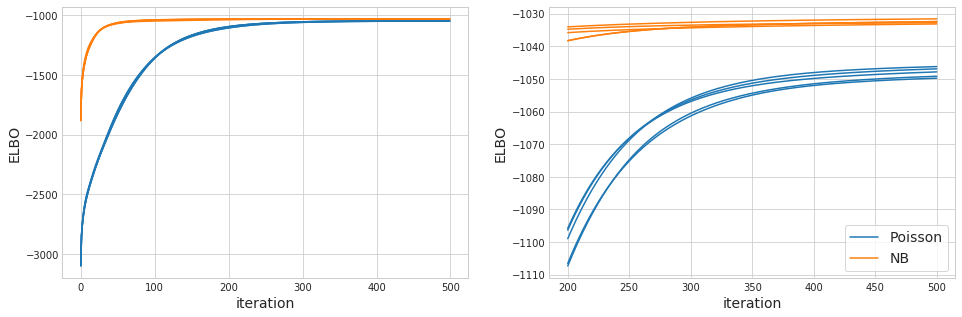

In [53]:
fig = plt.figure(figsize=(16, 5))
ax = plt.subplot(1, 2, 1)
for model in mpcmf_poi:
    plt.plot(np.array(model.inf.elbo_it)[:], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
for model in mpcmf_nbi:
    plt.plot(np.array(model.inf.elbo_it)[:], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
# plt.legend(frameon=True, fontsize=14)
plt.xlabel('iteration', fontsize=14)
plt.ylabel('ELBO', fontsize=14)

ax = plt.subplot(1, 2, 2)
for model in mpcmf_poi[:-1]:
    plt.plot(np.linspace(200, 500, 300), np.array(model.inf.elbo_it)[200:], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
plt.plot(np.linspace(200, 500, 300), np.array(mpcmf_poi[-1].inf.elbo_it)[200:], label='Poisson', color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
for model in mpcmf_nbi[:-1]:
    plt.plot(np.linspace(200, 500, 300), np.array(model.inf.elbo_it)[200:], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.plot(np.linspace(200, 500, 300), np.array(mpcmf_nbi[-2].inf.elbo_it)[200:], label='NB', color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.legend(frameon=True, fontsize=14)
plt.xlabel('iteration', fontsize=14)
plt.ylabel('ELBO', fontsize=14)

plt.savefig('5Kc500g_mpcmf_poi_nb.png', dpi=300, bbox_inches='tight')

In [18]:
mpcmf_svi_list = []
for mb_size in [100, 200, 500, 800, 1000]:
    mpcmf_nb_svi = mpCMF(X, n_components=K, scalings=True, sparsity=False, 
                      zero_inflation=True, empirical_bayes=False, do_imp=False, name="m-pCMF", minibatch_size=mb_size, 
                      nb=True)
    mpcmf_nb_svi.run(max_iter=50, max_time=60*30, do_holl=False, do_dll=True, 
              do_tsne=False, calc_test=False, verbose=True)
    
    mpcmf_svi_list.append(mpcmf_nb_svi)

m-pCMF:
Considering cell-specific scalings.
Considering NB structure.
Considering zero-inflated counts.
Running m-pCMF...
Iteration 2500/2500. ELBO: -1632.3260445. Improvement: 0.0387664. Elapsed: 0h28m29ss
Evaluating train-data log-likelihood...
Done.
m-pCMF:
Considering cell-specific scalings.
Considering NB structure.
Considering zero-inflated counts.
Running m-pCMF...
Iteration 1250/1250. ELBO: -1540.4031308. Improvement: -0.0511564. Elapsed: 0h10m40s
Evaluating train-data log-likelihood...
Done.
m-pCMF:
Considering cell-specific scalings.
Considering NB structure.
Considering zero-inflated counts.
Running m-pCMF...
Iteration 500/500. ELBO: -1471.4029355. Improvement: -0.0182283. Elapsed: 0h5m46s
Evaluating train-data log-likelihood...
Done.
m-pCMF:
Considering cell-specific scalings.
Considering NB structure.
Considering zero-inflated counts.
Running m-pCMF...
Iteration 300/300. ELBO: -1429.7063024. Improvement: 0.0113501. Elapsed: 0h4m41ss
Evaluating train-data log-likelihood...


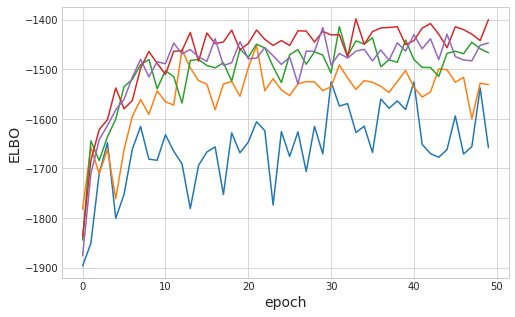

In [90]:
fig = plt.figure(figsize=(8, 5))

for model in mpcmf_svi_list[:]:
    plt.plot(np.array(model.inf.elbo_it[::int(model.inf.N/model.minibatch_size)]), label='M={}'.format(model.inf.minibatch_size))
# plt.legend(frameon=True, fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.ylabel('ELBO', fontsize=14)

plt.savefig('5Kc500g_mpcmf_nb_svi_noleg.png', dpi=300, bbox_inches='tight')

## ZINBayes

In [54]:
zinbayes_mc_1 = []
for i in range(5):
    obj = ZINBayes(n_components=K, zero_inflation=True, n_mc_samples=1, test_iterations=500, 
                   optimizer=None)
    zinbayes = ModelWrapper(obj, X, name='ZINBayes', do_imp=False)
    zinbayes.run(max_iter=500, do_silh=True, do_tsne=False, do_dll=True, do_holl=True, verbose=True)
    zinbayes_mc_1.append(zinbayes)

Considering zero-inflation.
Considering cell-specific scalings.
Running ZINBayes...
500/500 [100%] ██████████████████████████████ Elapsed: 100s | Loss: 1006.112
Evaluating train-data log-likelihood...
Done.
Considering zero-inflation.
Considering cell-specific scalings.
Running ZINBayes...
500/500 [100%] ██████████████████████████████ Elapsed: 100s | Loss: 1002.408
Evaluating train-data log-likelihood...
Done.
Considering zero-inflation.
Considering cell-specific scalings.
Running ZINBayes...
500/500 [100%] ██████████████████████████████ Elapsed: 101s | Loss: 1005.515
Evaluating train-data log-likelihood...
Done.
Considering zero-inflation.
Considering cell-specific scalings.
Running ZINBayes...
500/500 [100%] ██████████████████████████████ Elapsed: 100s | Loss: 1003.986
Evaluating train-data log-likelihood...
Done.
Considering zero-inflation.
Considering cell-specific scalings.
Running ZINBayes...
500/500 [100%] ██████████████████████████████ Elapsed: 100s | Loss: 1021.022
Evaluating 

In [ ]:
zinbayes_mc_5 = []
for i in range(5):
    obj = ZINBayes(n_components=K, zero_inflation=True, n_mc_samples=5, test_iterations=500, 
                   optimizer=None)
    zinbayes = ModelWrapper(obj, X, name='ZINBayes', do_imp=False)
    zinbayes.run(max_iter=500, do_silh=True, do_tsne=False, do_dll=True, do_holl=True, verbose=True)
    zinbayes_mc_5.append(zinbayes)

Considering zero-inflation.
Considering cell-specific scalings.
Running ZINBayes...
500/500 [100%] ██████████████████████████████ Elapsed: 424s | Loss: 962.862
Evaluating train-data log-likelihood...
Done.
Considering zero-inflation.
Considering cell-specific scalings.
Running ZINBayes...


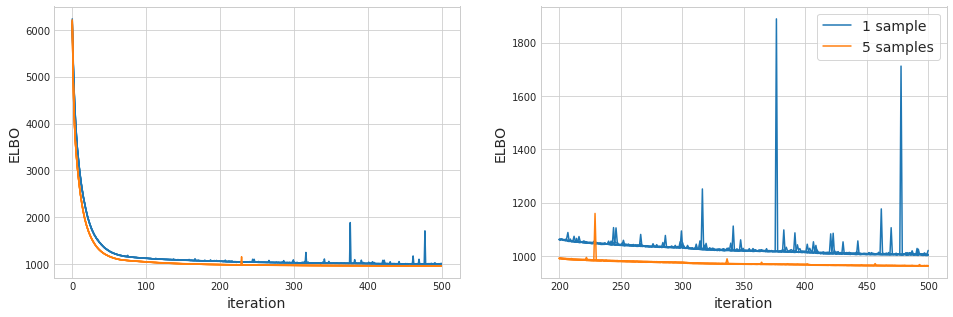

In [81]:
fig = plt.figure(figsize=(16, 5))
ax = plt.subplot(1, 2, 1)
for model in zinbayes_mc_1:
    plt.plot(np.array(model.model_inst.loss_dict['t_loss'])[:], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
for model in zinbayes_mc_5:
    plt.plot(np.array(model.model_inst.loss_dict['t_loss'])[:], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
# plt.legend(frameon=True, fontsize=14)
plt.xlabel('iteration', fontsize=14)
plt.ylabel('ELBO', fontsize=14)

ax = plt.subplot(1, 2, 2)
for model in zinbayes_mc_1[:-1]:
    plt.plot(np.linspace(200, 500, 300), np.array(model.model_inst.loss_dict['t_loss'])[200:], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
plt.plot(np.linspace(200, 500, 300), np.array(zinbayes_mc_1[-1].model_inst.loss_dict['t_loss'])[200:], label='1 sample', color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
for model in zinbayes_mc_5[:-1]:
    plt.plot(np.linspace(200, 500, 300), np.array(model.model_inst.loss_dict['t_loss'])[200:], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.plot(np.linspace(200, 500, 300), np.array(zinbayes_mc_5[-1].model_inst.loss_dict['t_loss'])[200:], label='5 samples', color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.legend(frameon=True, fontsize=14)
plt.xlabel('iteration', fontsize=14)
plt.ylabel('ELBO', fontsize=14)

plt.savefig('5Kc500g_zinbayes_mc_samples.png', dpi=300, bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(16, 5))
ax = plt.subplot(1, 2, 1)
for model in mpcmf_poi:
    plt.plot(np.array(model.inf.elbo_it)[:], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
for model in mpcmf_nbi:
    plt.plot(np.array(model.inf.elbo_it)[:], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
# plt.legend(frameon=True, fontsize=14)
plt.xlabel('iteration', fontsize=14)
plt.ylabel('ELBO', fontsize=14)

ax = plt.subplot(1, 2, 2)
for model in mpcmf_poi[:-1]:
    plt.plot(np.linspace(200, 500, 300), np.array(model.inf.elbo_it)[200:], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
plt.plot(np.linspace(200, 500, 300), np.array(mpcmf_poi[-1].inf.elbo_it)[200:], label='Poisson', color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
for model in mpcmf_nbi[:-1]:
    plt.plot(np.linspace(200, 500, 300), np.array(model.inf.elbo_it)[200:], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.plot(np.linspace(200, 500, 300), np.array(mpcmf_nbi[-2].inf.elbo_it)[200:], label='NB', color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.legend(frameon=True, fontsize=14)
plt.xlabel('iteration', fontsize=14)
plt.ylabel('ELBO', fontsize=14)

# plt.savefig('5Kc500g_mpcmf_poi_nb.png', dpi=300, bbox_inches='tight')

In [ ]:
zinbayes_svi_list = []
for mb_size in [100, 200, 500, 800, 1000]:
    obj = ZINBayes(n_components=K, zero_inflation=True, n_mc_samples=5, test_iterations=500, 
                   optimizer=None, minibatch_size=mb_size)
    zinbayes = ModelWrapper(obj, X, name='ZINBayes', do_imp=False)
    zinbayes.run(max_iter=500, do_silh=False, do_tsne=False, do_dll=False, do_holl=False, verbose=True)
    
    zinbayes_svi_list.append(zinbayes)

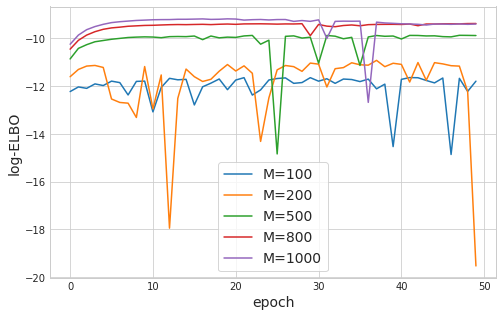

In [94]:
fig = plt.figure(figsize=(8, 5))

for model in zinbayes_svi_list[:]:
    plt.plot(-1 * np.log(np.array(model.model_inst.loss[:50])), label='M={}'.format(model.model_inst.minibatch_size))
plt.legend(frameon=True, fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.ylabel('log-ELBO', fontsize=14)

plt.savefig('5Kc500g_zinbayes_svi.png', dpi=300, bbox_inches='tight')

In [57]:
z

(5000, 500)